In [25]:
import os
import random
import numpy as np
import pandas as pd
import time
from PIL import Image 
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,utils,datasets
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from IPython.display import clear_output

In [26]:
assert torch.cuda.is_available()

In [27]:
batch_size = 10

In [84]:
MASK = 'radial'
MASK_PERCENT = '20'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])

In [85]:
def RF(image, mask, batch = False):	#both image and mask arg are (2,256,256) tensors
  if not batch:
    image = image.permute(1,2,0)
    mask = mask.permute(1,2,0)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(2,0,1)
    return res
  else:
    image = image.permute(0,2,3,1)
    mask = mask.permute(0,2,3,1)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(0,3,1,2)
    return res

def FhRh(frq, batch = False):
  if not batch:
    frq = frq.permute(1,2,0)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(2,0,1)
    return res
  else:
    frq = frq.permute(0,2,3,1)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(0,3,1,2)
    return res
  
def displayTensor(tnsr, name="image"):	#input tensor is (2,256,256)
  real = tnsr[0]
  image = (real+1)*255/2
  image = np.array(image, dtype="uint8")
  plt.imshow(image, cmap='gray', vmin=0, vmax=255)
  # cv2.imshow(name, image)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [86]:
class Dataset_train(Dataset):
	def __init__(self, data_dir='/content/drive/My Drive/CS 736/data/brain/db_train', mask_path='/content/drive/My Drive/CS 736/data/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PERCENT), transform=train_transforms):
		self.us_train_data = []
		self.transform=transform
		self.mask = cv2.imread(mask_path)
		self.mask = cv2.cvtColor(self.mask, cv2.COLOR_BGR2GRAY)/255
		self.mask2 = torch.zeros(2,256,256)
		self.mask2[0] = torch.Tensor(self.mask)
		self.mask2[1] = torch.Tensor(self.mask)
		i=0
		for filename in os.listdir(data_dir):
			image = Image.open('{}/{}'.format(data_dir, filename))
			# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			# image = 2*(image/255) - 1
			self.us_train_data.append(image)
			i = i+1

	def __len__(self):
		return len(self.us_train_data)

	def __getitem__(self, idx):
		sample = self.us_train_data[idx]
		sample2 = (self.transform(sample))*2-1
		image = torch.zeros(2,256,256)
		image[0] = sample2
		image[1] = image[1]-1
		# self.us_train_data[idx,0] = (self.transform(sample))*2-1
		# sample = sample*2 -1
		# image = self.us_train_data[idx]
		frq = RF(image, self.mask2)
		res = FhRh(frq)
		fin = tuple([image,frq,res])
		return fin

In [87]:
train_data = Dataset_train()
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [88]:
class ResidualCell(nn.Module):
  def __init__(self, n_filters):
    super(ResidualCell, self).__init__()
    #Residual connections, (H,W) remain same 
    self.conv_i = nn.Conv2d(n_filters, n_filters, (3,3), 1, 1) #Why is this layer needed?
    self.conv_m = nn.Conv2d(n_filters, int(n_filters/2), (3,3), 1, 1)
    self.conv_o = nn.Conv2d(int(n_filters/2), n_filters, (3,3), 1, 1)
    
    self.res_net = nn.Sequential(self.conv_i, nn.ReLU(), self.conv_m, nn.ReLU(), self.conv_o, nn.ReLU())

  def forward(self, x):
    return x+self.res_net(x)

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
class EncoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0):
    super(EncoderCell, self).__init__()

    self.conv_a = nn.Conv2d(n_in, n_res, (3,3), 2, padding=pad)
    self.res = ResidualCell(n_res)
    self.conv_b = nn.Conv2d(n_res, n_res, (3,3), 1)

    self.encoder = nn.Sequential(self.conv_a, nn.ReLU(), self.res, self.conv_b, nn.ReLU())

  def forward(self, x):
    return self.encoder(x)

In [75]:
class DecoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0):
    super(DecoderCell, self).__init__()

    self.deconv_a = nn.ConvTranspose2d(n_in, n_res, (3,3), 1)
    self.res = ResidualCell(n_res)
    self.deconv_b = nn.ConvTranspose2d(n_res, n_res, (3,3), 2, output_padding=pad)

    self.decoder = nn.Sequential(self.deconv_a, nn.ReLU(), self.res, self.deconv_b, nn.ReLU())

  def forward(self, x):
    return self.decoder(x)

In [76]:
class SubGenerator(nn.Module):
  """
  Input: Zero filling imperfect reconstruction by inverse of undersampled fourier transform
  Output: Full image which (should) belongs to the set of all possible perfect reconstructions
  """
  def __init__(self, n):
    super(SubGenerator, self).__init__()
    #Input channels = 2 

    #ConvEncoder
    self.ec0 = EncoderCell(2,n)
    self.ec1 = EncoderCell(n,2*n)
    self.ec2 = EncoderCell(2*n,4*n)
    self.ec3 = EncoderCell(4*n,8*n)

    #ConvDecoder
    self.dc3 = DecoderCell(8*n,4*n)
    self.dc2 = DecoderCell(4*n,2*n,1)
    self.dc1 = DecoderCell(2*n,n)
    self.dc0 = DecoderCell(n,n,1)

    #Output 
    self.out = nn.Sequential(nn.Conv2d(n,2,(3,3),1,1), #Real and Complex channels as outputs?
                             nn.Tanh())

  def forward(self, x):
    #With Residual Connections
    # print(x.shape)
    e0 = self.ec0(x)
    # print(e0.shape)
    e1 = self.ec1(e0)
    # print(e1.shape)
    e2 = self.ec2(e1)
    # print(e2.shape)
    e3 = self.ec3(e2)
    # print(e3.shape)

    d3 = self.dc3(e3)
    # print(d3.shape)
    d2 = self.dc2(d3+e2)
    # print(d2.shape)
    d1 = self.dc1(d2+e1)
    # print(d1.shape)
    d0 = self.dc0(d1+e0)
    # print(d0.shape)

    y = self.out(d0)
    # print(y.shape)

    return y


In [77]:
class Generator(nn.Module):
  def __init__(self, n):
    super(Generator, self).__init__()

    self.reconGAN = SubGenerator(n)
    self.refineGAN = SubGenerator(n)

  def forward(self, x):
    y = x+self.reconGAN(x)
    z = y+self.refineGAN(y) 
    return (y,z)

In [78]:
class Discriminator(nn.Module):
  def __init__(self, n):
    super(Discriminator, self).__init__()
    
    #Downsample Layers

    self.ec0 = EncoderCell(2,n)
    self.ec1 = EncoderCell(n,2*n)
    self.ec2 = EncoderCell(2*n,4*n)
    self.ec3 = EncoderCell(4*n,8*n)

    #Probability Output
    self.downsampler = nn.Sequential(self.ec0, self.ec1, self.ec2, self.ec3)
    #Abstract latent space size in final layer?
    # self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1), nn.Sigmoid()) #With BCELoss (not numerically stable)
    self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1)) #With stable bceloss with logits

  def forward(self, x):
    d = self.downsampler(x)
    y = self.out(d)
    # return torch.squeeze(y)
    return y

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 100
# batch_size = 100
num_filters = 64
lr = 0.0001

criterion_D = nn.BCEWithLogitsLoss()
criterionG_image = nn.L1Loss()
criterionG_freq = nn.L1Loss()

real_label = 1
fake_label = 0

alpha = 1.0
gamma = 10.0

netG = Generator(num_filters)
netD = Discriminator(num_filters)

opt_D = optim.Adam(netD.parameters(), lr=lr)
opt_G = optim.Adam(netG.parameters(), lr=lr)

cuda


In [60]:
batch_mask = train_data.mask2.repeat(batch_size,1,1,1)
batch_mask = batch_mask.to(device)
# mask.shape

In [61]:
print(netG)

Generator(
  (reconGAN): SubGenerator(
    (ec0): EncoderCell(
      (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (res): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): ReLU()
        )
      )
      (conv_b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (encoder): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): ResidualCell(
          (conv_i): Conv2d(64, 

In [62]:
print(netD)

Discriminator(
  (ec0): EncoderCell(
    (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
    (res): ResidualCell(
      (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res_net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): ReLU()
      )
    )
    (conv_b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (encoder): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (co

In [63]:
G_parameters = filter(lambda p: p.requires_grad, netG.parameters())
Gparams = sum([np.prod(p.size()) for p in G_parameters])
print("Generator Parameters:",Gparams)
D_parameters = filter(lambda p: p.requires_grad, netD.parameters())
Dparams = sum([np.prod(p.size()) for p in D_parameters])
print("Discriminator Parameters:",Dparams)

Generator Parameters: 29951428
Discriminator Parameters: 11016033


In [64]:
Generated_Images = []
G_loss_img = []
G_loss_freq = []
G_loss_adv = []
G_loss_total = []

D_loss_real = []
D_loss_fake = []
D_loss_total = []

netD.to(device)
netD.train()
netG.to(device)
netG.train()

Generator(
  (reconGAN): SubGenerator(
    (ec0): EncoderCell(
      (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (res): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): ReLU()
        )
      )
      (conv_b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (encoder): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): ResidualCell(
          (conv_i): Conv2d(64, 

Training:<br>
We will train the D and G in an alternating fashion. <br>



Epoch: 0 G Loss: 13.55 D Loss: 1.81


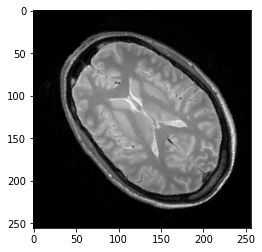

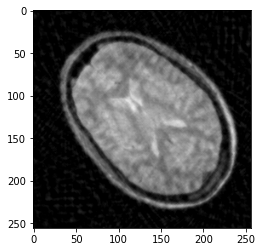

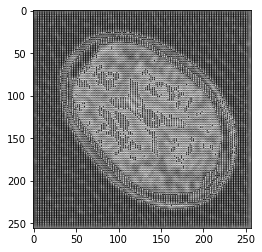

Epoch: 1 G Loss: 6.15 D Loss: 4.54


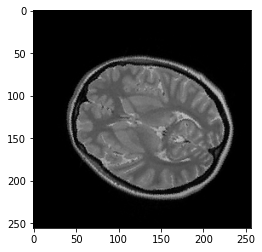

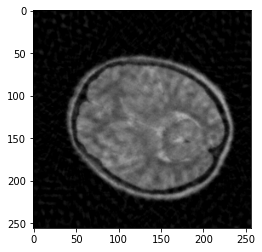

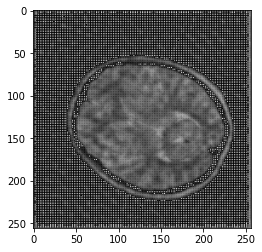

Epoch: 2 G Loss: 4.42 D Loss: 1.3


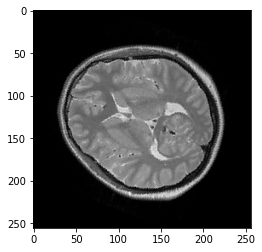

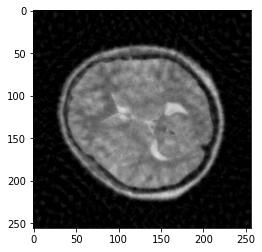

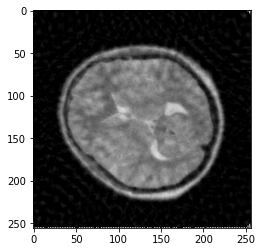

Epoch: 3 G Loss: 4.05 D Loss: 1.3


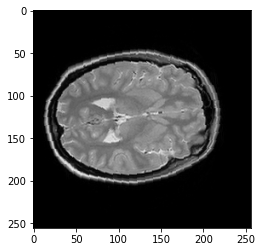

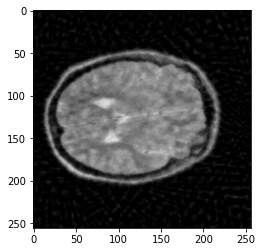

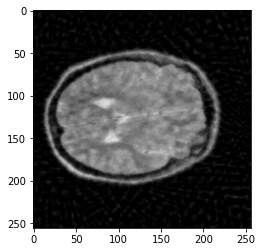

In [ ]:
# def GANvtrain(netG, netD, model_params, hyper_params criterions, optimizers, dataloader)
image_recon=[]
loss_arr=[]

for epoch in range(epochs):
  for batch_idx, im_tuple in enumerate(dataloader, 0):

    full_image_batch = im_tuple[0].to(device)
    us_kspace_batch = im_tuple[1].to(device)
    zf_recon_batch = im_tuple[2].to(device)

    gen_full_image_batch = netG(zf_recon_batch)[1]
    # print("Generated Img Batch")
    real_logits = netD(full_image_batch).view(-1)
    fake_logitsD = netD(gen_full_image_batch.detach()).view(-1)

    # print("Computed Real and Fake Logits")
    
    # recon_image_batch = netG(torch.ifft(mask*torch.fft(full_image_batch.permute([0,2,3,1]),2)).permute([0,3,1,2]))[1]
    # recon_kspace_batch = (mask*torch.fft(netG(torch.ifft(us_kspace_batch.permute([0,2,3,1]),2).permute([0,3,1,2]))[1].permute([0,2,3,1]),2)).permute([0,3,1,2])
    # recon_image_batch = netG(FhRh(RF(full_image_batch, batch_mask, batch = True), batch = True))[0]
    # recon_kspace_batch = RF(netG(FhRh(us_kspace_batch, batch=True))[0], batch_mask, batch = True)
    
    
    #Discriminator Training 
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_D.zero_grad()
    
    real_d_loss = criterion_D(real_logits, torch.full([batch_size], real_label, device=device))
    D_loss_real.append(real_d_loss)
    real_d_loss.backward()

    fake_d_loss = criterion_D(fake_logitsD, torch.full([batch_size], fake_label, device=device))
    D_loss_fake.append(fake_d_loss)
    fake_d_loss.backward()

    with torch.no_grad():
      d_loss_total = real_d_loss+fake_d_loss
    D_loss_total.append(d_loss_total)

    opt_D.step()

    #Generator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_G.zero_grad()

    fake_logitsG = netD(gen_full_image_batch).view(-1)
    adv_g_loss = criterion_D(fake_logitsG, torch.full([batch_size], real_label, device=device))
    G_loss_adv.append(adv_g_loss)
    adv_g_loss.backward()

    recon_image_batch = netG(zf_recon_batch)[1] #Because same underlying image
    g_image_loss = gamma*criterionG_image(recon_image_batch,full_image_batch)
    G_loss_img.append(g_image_loss)
    g_image_loss.backward()

    recon_kspace_batch = RF(netG(zf_recon_batch)[1], batch_mask, batch = True) #Because same underlying image
    g_freq_loss = alpha*criterionG_freq(recon_kspace_batch,us_kspace_batch)
    G_loss_freq.append(g_freq_loss)
    g_freq_loss.backward()

    with torch.no_grad():
      g_loss_total = adv_g_loss+g_image_loss+g_freq_loss
    G_loss_total.append(g_loss_total)

    opt_G.step()   

  print("Epoch:", epoch, "G Loss:", float('%.2f' % g_loss_total.data.tolist()), "D Loss:", float('%.2f' % d_loss_total.data.tolist()))

  # if epoch%25==0:
  #   clear_output(wait=True)

  if epoch%5>=0:
    disp_img = recon_image_batch[0].cpu().detach().numpy()
    disp_img2 = full_image_batch[0].cpu().detach().numpy()
    disp_img3 = zf_recon_batch[0].cpu().detach().numpy()
    
    displayTensor(disp_img2)
    plt.show()
    displayTensor(disp_img3)
    plt.show()
    displayTensor(disp_img)
    plt.show()
    # print(recon_image_batch.size())

  image_recon.append(disp_img)
  # loss_arr.append(g_image_loss)


In [ ]:
print(batch_size)

In [ ]:
plt.plot(G_loss_img)